# Fine-tune SAM on customized datasets (3D example)
1. Prepare original 3D images `data/FLARE22Train/` (Download link:https://zenodo.org/record/7860267) 
2. Run `pre_CT.py` for pre-processing. Expected output: `./data/Npz_files/CT_Abd-Gallbladder_`
3. Start this fine-tuning tutorial

In [2]:
# %% set up environment
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [4]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()


In [5]:
# %% test dataset class and dataloader
npz_tr_path = 'data/FLARE22Train/preprocess/CT_Abd-Gallbladder/train'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(576, 256, 64, 64), self.ori_gts.shape=(576, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [6]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/FLARE22Train/preprocess/CT_Abd-Gallbladder/train'
work_dir = './work_dir'
task_name = 'CT_Abd-Gallbladder'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()

# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [7]:
#%% train
num_epochs = 50
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))


self.img_embeddings.shape=(576, 256, 64, 64), self.ori_gts.shape=(576, 256, 256)


100%|██████████| 9/9 [01:31<00:00, 10.19s/it]


EPOCH: 0, Loss: 0.3033849336206913


100%|██████████| 9/9 [01:26<00:00,  9.63s/it]


EPOCH: 1, Loss: 0.22189919464290142


100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


EPOCH: 2, Loss: 0.17948129773139954


100%|██████████| 9/9 [01:26<00:00,  9.65s/it]


EPOCH: 3, Loss: 0.15993271209299564


100%|██████████| 9/9 [01:27<00:00,  9.70s/it]


EPOCH: 4, Loss: 0.15022844355553389


100%|██████████| 9/9 [01:28<00:00,  9.86s/it]


EPOCH: 5, Loss: 0.14258781727403402


100%|██████████| 9/9 [01:27<00:00,  9.72s/it]


EPOCH: 6, Loss: 0.1346863005310297


100%|██████████| 9/9 [01:27<00:00,  9.70s/it]


EPOCH: 7, Loss: 0.12920731771737337


100%|██████████| 9/9 [01:27<00:00,  9.72s/it]


EPOCH: 8, Loss: 0.13037975132465363


100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


EPOCH: 9, Loss: 0.12731724511832


100%|██████████| 9/9 [01:26<00:00,  9.64s/it]


EPOCH: 10, Loss: 0.11009241919964552


100%|██████████| 9/9 [01:25<00:00,  9.50s/it]


EPOCH: 11, Loss: 0.11709812562912703


100%|██████████| 9/9 [01:25<00:00,  9.53s/it]


EPOCH: 12, Loss: 0.11710990779101849


100%|██████████| 9/9 [01:25<00:00,  9.49s/it]


EPOCH: 13, Loss: 0.11008414346724749


100%|██████████| 9/9 [01:25<00:00,  9.53s/it]


EPOCH: 14, Loss: 0.10302454512566328


100%|██████████| 9/9 [01:25<00:00,  9.46s/it]


EPOCH: 15, Loss: 0.11195424571633339


100%|██████████| 9/9 [01:25<00:00,  9.50s/it]


EPOCH: 16, Loss: 0.10428767744451761


100%|██████████| 9/9 [01:25<00:00,  9.50s/it]


EPOCH: 17, Loss: 0.1037686550989747


100%|██████████| 9/9 [01:25<00:00,  9.49s/it]


EPOCH: 18, Loss: 0.10235914867371321


100%|██████████| 9/9 [01:25<00:00,  9.50s/it]


EPOCH: 19, Loss: 0.09740209858864546


100%|██████████| 9/9 [01:25<00:00,  9.48s/it]


EPOCH: 20, Loss: 0.09686908684670925


100%|██████████| 9/9 [01:25<00:00,  9.52s/it]


EPOCH: 21, Loss: 0.09703425224870443


100%|██████████| 9/9 [01:26<00:00,  9.62s/it]


EPOCH: 22, Loss: 0.09596779849380255


100%|██████████| 9/9 [01:26<00:00,  9.63s/it]


EPOCH: 23, Loss: 0.09303591400384903


100%|██████████| 9/9 [01:26<00:00,  9.66s/it]


EPOCH: 24, Loss: 0.09837697073817253


100%|██████████| 9/9 [01:26<00:00,  9.67s/it]


EPOCH: 25, Loss: 0.09616539161652327


100%|██████████| 9/9 [01:27<00:00,  9.67s/it]


EPOCH: 26, Loss: 0.10022091306746006


100%|██████████| 9/9 [01:26<00:00,  9.64s/it]


EPOCH: 27, Loss: 0.09768065344542265


100%|██████████| 9/9 [01:27<00:00,  9.67s/it]


EPOCH: 28, Loss: 0.09285620972514153


100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


EPOCH: 29, Loss: 0.08969506714493036


100%|██████████| 9/9 [01:27<00:00,  9.67s/it]


EPOCH: 30, Loss: 0.09013512078672647


100%|██████████| 9/9 [01:26<00:00,  9.63s/it]


EPOCH: 31, Loss: 0.09488706942647696


100%|██████████| 9/9 [01:26<00:00,  9.64s/it]


EPOCH: 32, Loss: 0.09225215949118137


100%|██████████| 9/9 [01:26<00:00,  9.66s/it]


EPOCH: 33, Loss: 0.08980354387313128


100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


EPOCH: 34, Loss: 0.09063394647091627


100%|██████████| 9/9 [01:27<00:00,  9.67s/it]


EPOCH: 35, Loss: 0.0909503297880292


100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


EPOCH: 36, Loss: 0.0876477537676692


100%|██████████| 9/9 [01:27<00:00,  9.69s/it]


EPOCH: 37, Loss: 0.09033026080578566


100%|██████████| 9/9 [01:26<00:00,  9.66s/it]


EPOCH: 38, Loss: 0.08708911668509245


100%|██████████| 9/9 [01:26<00:00,  9.65s/it]


EPOCH: 39, Loss: 0.08534187264740467


100%|██████████| 9/9 [01:26<00:00,  9.63s/it]


EPOCH: 40, Loss: 0.08591487538069487


100%|██████████| 9/9 [01:26<00:00,  9.66s/it]


EPOCH: 41, Loss: 0.08264763746410608


100%|██████████| 9/9 [01:25<00:00,  9.53s/it]


EPOCH: 42, Loss: 0.08537907572463155


100%|██████████| 9/9 [01:25<00:00,  9.54s/it]


EPOCH: 43, Loss: 0.0893921023234725


100%|██████████| 9/9 [01:30<00:00, 10.01s/it]


EPOCH: 44, Loss: 0.08797390479594469


100%|██████████| 9/9 [01:32<00:00, 10.24s/it]


EPOCH: 45, Loss: 0.08441495802253485


100%|██████████| 9/9 [01:31<00:00, 10.18s/it]


EPOCH: 46, Loss: 0.08200126048177481


100%|██████████| 9/9 [01:31<00:00, 10.21s/it]


EPOCH: 47, Loss: 0.08174878545105457


100%|██████████| 9/9 [01:31<00:00, 10.18s/it]


EPOCH: 48, Loss: 0.0820508198812604


100%|██████████| 9/9 [01:32<00:00, 10.27s/it]


EPOCH: 49, Loss: 0.07918381039053202


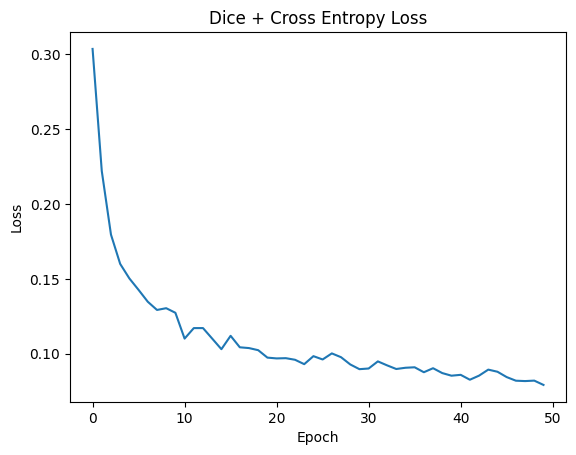

In [8]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [10]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
npz_ts_path = 'data/FLARE22Train/preprocess/CT_Abd-Gallbladder/test'
test_npzs = sorted(os.listdir(npz_ts_path))
# random select a test case
npz_idx = np.random.randint(0, len(test_npzs))
npz = np.load(join(npz_ts_path, test_npzs[npz_idx]))
imgs = npz['imgs']
gts = npz['gts']

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

ori_sam_segs = []
medsam_segs = []
bboxes = []
for img, gt in zip(imgs, gts):
    bbox = get_bbox_from_mask(gt)
    bboxes.append(bbox)
    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(img)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox, multimask_output=False)
    ori_sam_segs.append(ori_sam_seg[0])
    
    # predict the segmentation mask using the fine-tuned model
    H, W = img.shape[:2]
    resize_img = sam_trans.apply_image(img)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox, (H, W))
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        medsam_segs.append(medsam_seg)

In [11]:
#%% compute the DSC score
ori_sam_segs = np.stack(ori_sam_segs, axis=0)
medsam_segs = np.stack(medsam_segs, axis=0)
ori_sam_dsc = compute_dice_coefficient(gts>0, ori_sam_segs>0)
medsam_dsc = compute_dice_coefficient(gts>0, medsam_segs>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))


Original SAM DSC: 0.7387 MedSAM DSC: 0.9162


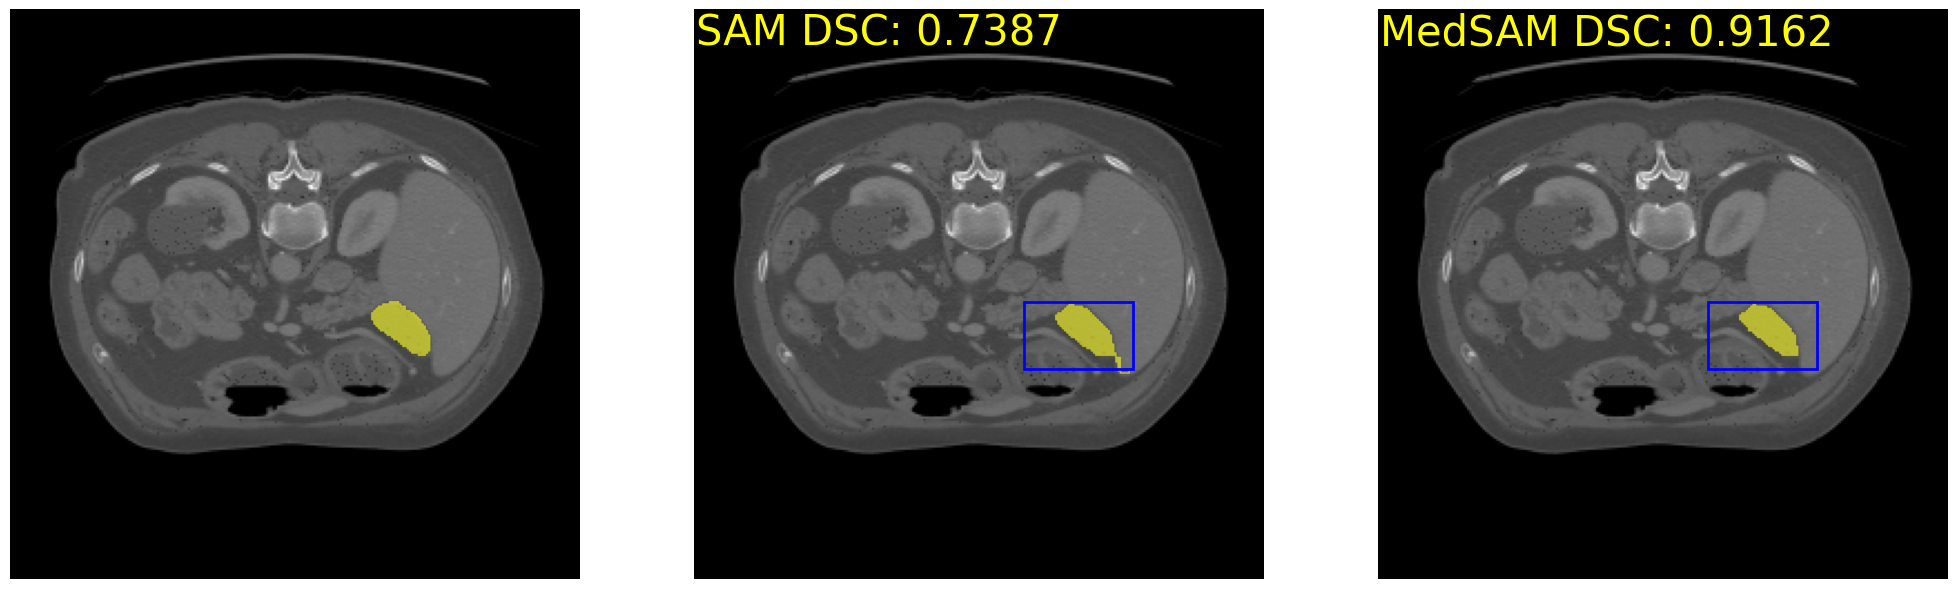

In [12]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


img_id = int(imgs.shape[0]/2)  # np.random.randint(imgs.shape[0])
_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(imgs[img_id])
show_mask(gts[img_id], axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(imgs[img_id])
show_mask(ori_sam_segs[img_id], axs[1])
show_box(bboxes[img_id], axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(imgs[img_id])
show_mask(medsam_segs[img_id], axs[2])
show_box(bboxes[img_id], axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()
